# 1. Собрать данные по дневным ценам активов (акций) и дневным объемам продаж на заданном фондовом рынке за указанный период. Добавить (если нет) данные по индексу рынка.

In [1]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials

**Скачал список компаний Франкфуртской биржи**

In [2]:
start_date = '2019-01-02'
end_date = '2020-01-01'

def download_ticker(ticker, start=start_date, end=end_date):
    return yf.download(ticker, start, end)

**Индекс DAX представляет собой главный индекс Франфуртской биржи.  Индекс вычисляется как среднее взвешенное по капитализации значение цен акций крупнейших акционерных компаний Германии (при этом капитализация рассчитывается лишь на основе акций, находящихся в свободном обращении). Индекс учитывает также полученные в виде дивидендов доходы по акциям, предполагая, что дивиденды реинвестируются в акцию, по которой был получен данный дивиденд. Таким образом, индекс отражает суммарный доход по капиталу.**

In [3]:
DAX_index = download_ticker('^GDAXI')
DAX_index.drop(['Open', 'High', 'Low', 'Close'], axis=1, inplace=True)
DAX_index

[*********************100%***********************]  1 of 1 completed


,Adj Close,Volume
Date,,
2019-01-02,10580.190430,79626700
2019-01-03,10416.660156,84733800
2019-01-04,10767.690430,95339500
2019-01-07,10747.809570,71151400
2019-01-08,10803.980469,93672200
...,...,...
2019-12-19,13211.959961,84018200
2019-12-20,13318.900391,170723200
2019-12-23,13300.980469,56215400


**Выкачал тикеры, удалил из датафрейма компании которые не скачались. Перекачивать не нужно, сохранено в бинарник.**

**Следующая ячейка загружает обьекты из файлов в память**

In [4]:
companies_list_csv = 'companies_list.csv'
companies_list = pd.read_csv(companies_list_csv, index_col='index')
companies_list

,Ticker,Company,Sector,Subsector,Annual LogReturn,E,Risk
index,,,,,,,
0,TGT,11 88 0 SOLUTIONS AG,Telecommunication,Telecommunication Services,0.741353,0.002954,0.020980
1,UUU,3U HOLDING AG,Industrial,Industrial Products & Services,-0.441075,-0.001757,0.041125
2,VSC,4SC AG,Pharma & Healthcare,Biotechnology,-0.271261,-0.001185,0.017601
3,ARL,AAREAL BANK AG,Banks,Mortgage Banks,0.468157,0.001865,0.034848
4,APM,"AD PEPPER MEDIA EO 0,05",Media,Advertising,0.192979,0.000769,0.037671
...,...,...,...,...,...,...,...
87,EQS,EQS GROUP AG NA O.N.,Software,IT-Services,0.004125,0.000018,0.026577
88,MUX,MUTARES KGAA NA O.N.,Financial Services,Private Equity & Venture Capital,-0.233334,-0.000930,0.036996
89,NTG,NABALTEC AG INH.,Industrial,Industrial Products & Services,0.008308,0.000033,0.012426


In [5]:
from os import listdir
from os.path import isfile, join
tickers_folder = 'tickers'
onlyfiles = [f for f in listdir(tickers_folder) if isfile(join(tickers_folder, f))]
tickers = []
for i in range(len(onlyfiles)):
    path = tickers_folder + '/' + str(i)
    tickers.append(pd.read_csv(path, index_col='Date'))
tickers[0]

,Adj Close,Volume,LogReturn
Date,,,
2019-01-02,62.470619,4549300,NaN
2019-01-03,61.614986,4562200,-0.013697
2019-01-04,62.461220,4825900,0.013734
2019-01-07,65.517059,7630600,0.048924
2019-01-08,65.451233,6756000,-0.001005
...,...,...,...
2019-12-24,124.720284,1643400,0.001636
2019-12-26,125.050156,2197900,0.002645
2019-12-27,125.360641,2233600,0.002483


In [13]:
len(tickers)

108

# 2. Преобразовать данные по ценам в данные по доходностям (используйте логарифмическую доходность). Вычислите оценки ожидаемых доходностей и стандартных отклонений и постройте «карту» активов в системе координат (σ, E).

**По взвешенной цене закрытия считаю логарифмические доходности за периоды.**

In [14]:
count = 0
for ticker in tickers:
    log_returns = []
    close_price = ticker['Adj Close']
    log_returns.append(None)
    for i in range(1, len(close_price)):
        log_return = (close_price[i] - close_price[i - 1]) / close_price[i - 1]
        log_returns.append(log_return)
    ticker['LogReturn'] = log_returns
    count += 1

In [15]:
tickers[0]

,Adj Close,Volume,LogReturn
Date,,,
2019-01-02,62.470619,4549300,NaN
2019-01-03,61.614986,4562200,-0.013697
2019-01-04,62.461220,4825900,0.013734
2019-01-07,65.517059,7630600,0.048924
2019-01-08,65.451233,6756000,-0.001005
...,...,...,...
2019-12-24,124.720284,1643400,0.001636
2019-12-26,125.050156,2197900,0.002645
2019-12-27,125.360641,2233600,0.002483


**Для каждого актива высчитываю логарифмическую доходность за год (по сумме доходностей за отдельные периоды), а также оценку доходности как среднее от доходностей за отдельные периоды.**

In [16]:
companies_list['Annual LogReturn'] = [tickers[i]['LogReturn'].sum() for i, row in companies_list.iterrows()]
companies_list['E'] = [tickers[i]['LogReturn'].mean() for i, row in companies_list.iterrows()]

**Риск - стандартное отклонение доходности**

In [17]:
companies_list['Risk'] = [tickers[i]['LogReturn'].std() for i, row in companies_list.iterrows()]

**В некоторых слишком мало наблюдений, удалил все где меньше 100 периодов.**

In [ ]:
little_observations = []
for i in range(len(tickers)):
    if len(tickers[i]) < 100:
        little_observations.append(i)

In [ ]:
little_observations

In [ ]:
companies_list = companies_list.drop(little_observations)

In [ ]:
companies_list = companies_list.reset_index(drop=True)

**Итоговые данные с которыми можно работать:**

In [6]:
companies_list

,Ticker,Company,Sector,Subsector,Annual LogReturn,E,Risk
index,,,,,,,
0,TGT,11 88 0 SOLUTIONS AG,Telecommunication,Telecommunication Services,0.741353,0.002954,0.020980
1,UUU,3U HOLDING AG,Industrial,Industrial Products & Services,-0.441075,-0.001757,0.041125
2,VSC,4SC AG,Pharma & Healthcare,Biotechnology,-0.271261,-0.001185,0.017601
3,ARL,AAREAL BANK AG,Banks,Mortgage Banks,0.468157,0.001865,0.034848
4,APM,"AD PEPPER MEDIA EO 0,05",Media,Advertising,0.192979,0.000769,0.037671
...,...,...,...,...,...,...,...
87,EQS,EQS GROUP AG NA O.N.,Software,IT-Services,0.004125,0.000018,0.026577
88,MUX,MUTARES KGAA NA O.N.,Financial Services,Private Equity & Venture Capital,-0.233334,-0.000930,0.036996
89,NTG,NABALTEC AG INH.,Industrial,Industrial Products & Services,0.008308,0.000033,0.012426


In [7]:
import matplotlib.pyplot as plt

In [10]:
for i, row in companies_list.iterrows():
    if row['Risk'] > 0.1:
        companies_list.drop(i, inplace=True)

Text(0, 0.5, 'E (Лог. доходность)')

<Figure size 720x720 with 0 Axes>

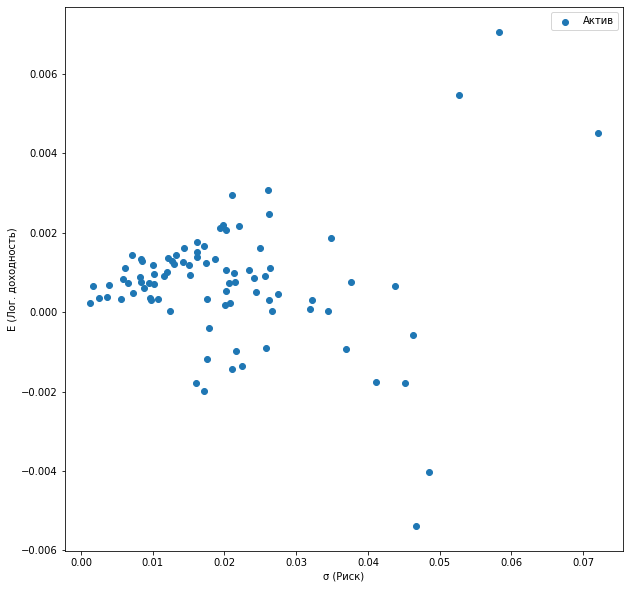

In [11]:
plt.figure(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(companies_list['Risk'], companies_list['E'], label='Актив')
ax.legend()
plt.xlabel('σ (Риск)')
plt.ylabel('E (Лог. доходность)')

Даже несмотря на то, что получилось собрать не очень много данных о компаниях, карта активов дает довольно четкий рисунок. Можно увидеть, что активы имеют тенденцию располагаться примерно в одной области графика.

# 3. Рассмотрите портфель с равными долями капитала и отметьте его на карте активов в системе координат (σ, E). Дайте характеристику этому портфелю.

In [12]:
balanced_E = companies_list['E'].mean()
balanced_Risk = companies_list['E'].std()
print('Сбалансированный портфель:\nE =', balanced_E, '\nσ =', balanced_Risk)

Сбалансированный портфель:
E = 0.0007227293321742409 
σ = 0.00161222089535056


<Figure size 720x720 with 0 Axes>

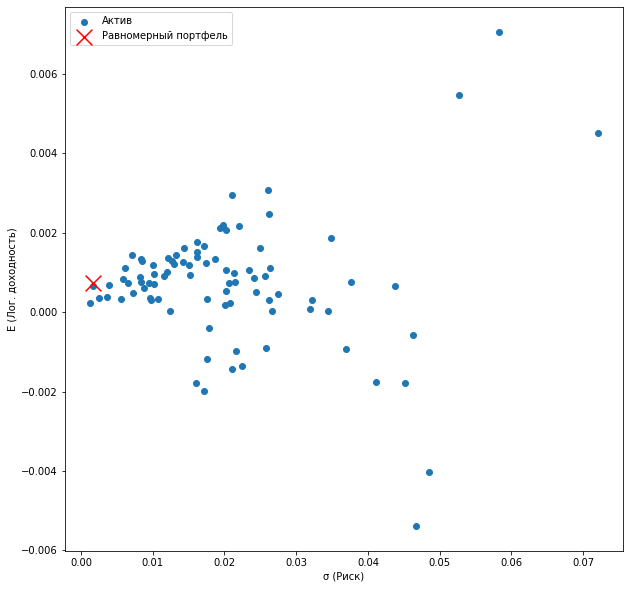

In [13]:
plt.figure(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(companies_list['Risk'], companies_list['E'], label='Актив')
ax.scatter([balanced_Risk], [balanced_E], marker='x', color='red', s=[250], label='Равномерный портфель')
ax.legend()
plt.xlabel('σ (Риск)')
plt.ylabel('E (Лог. доходность)')
plt.show()

На карте видно, что равномерный портфель имеет небольшой риск и небольшую доходность относительно других активов. При этом доходность положительная.

# 4. Рассмотрите индекс рынка и отметьте его на карте активов в системе координат (σ,E). Дайте характеристику индексу рынка.

In [14]:
log_returns = []
close_price = DAX_index['Adj Close']
log_returns.append(None)
for i in range(1, len(close_price)):
    log_return = (close_price[i] - close_price[i - 1]) / close_price[i - 1]
    log_returns.append(log_return)
DAX_index['LogReturn'] = log_returns
DAX_index

,Adj Close,Volume,LogReturn
Date,,,
2019-01-02,10580.190430,79626700,NaN
2019-01-03,10416.660156,84733800,-0.015456
2019-01-04,10767.690430,95339500,0.033699
2019-01-07,10747.809570,71151400,-0.001846
2019-01-08,10803.980469,93672200,0.005226
...,...,...,...
2019-12-19,13211.959961,84018200,-0.000771
2019-12-20,13318.900391,170723200,0.008094
2019-12-23,13300.980469,56215400,-0.001345


In [15]:
dax_annual_log_return = DAX_index['LogReturn'].sum()
dax_E = DAX_index['LogReturn'].mean()
dax_Risk = DAX_index['LogReturn'].std()
print('Годовая логарифмическая доходность рынка по индексу DAX =', dax_annual_log_return)
print('Оценка логарифмическая доходности рынка по индексу DAX =', dax_E)
print('Оценка рынка по индексу DAX =', dax_Risk)

Годовая логарифмическая доходность рынка по индексу DAX = 0.2347641154811551
Оценка логарифмическая доходности рынка по индексу DAX = 0.0009390564619246206
Оценка рынка по индексу DAX = 0.008832932682857111


<Figure size 720x720 with 0 Axes>

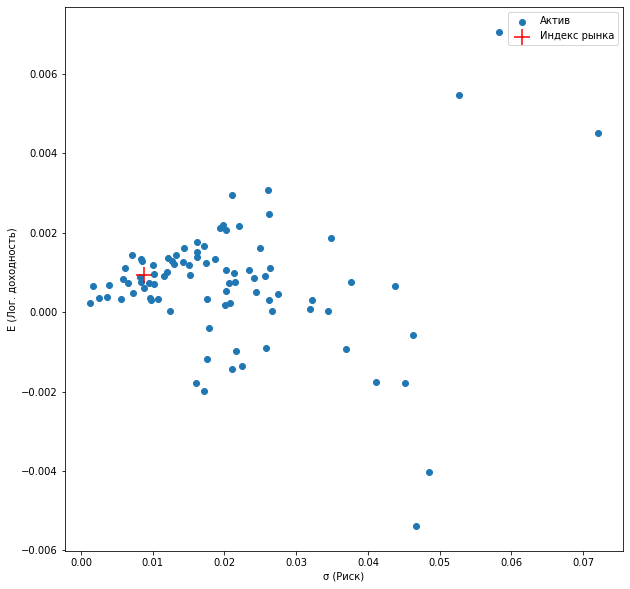

In [16]:
plt.figure(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(companies_list['Risk'], companies_list['E'], label='Актив')
ax.scatter([dax_Risk], [dax_E], marker='+', color='red', s=[250], label='Индекс рынка')
ax.legend()
plt.xlabel('σ (Риск)')
plt.ylabel('E (Лог. доходность)')
plt.show()

Индекс рынка имеет риск немного больше, чем равномерный портфель, при этом его доходность почти не отличается от равномерного портфеля.
Можно предположить, что это означает, что рынок находится в стабильном состоянии и медленно растет.

# 5. Задайте уровень риска и оцените VaR (Value at Risk = Сумма под Риском) для активов вашего рынка.

Для нахождения суммы под риском,были выбраны два показателя доверия гамма: 0.9 и 0.95. Сумма под риском - квантиль уровня гамма, где гамма — это наименьшая величина потерь, такая, что убыток превысит это значение с вероятностью не большей (1 - гамма)

Получаем точку, которая соответствовует требуемому уровню доверительной вероятности

In [18]:
import copy
import numpy as np

Var1_np = []
Var2_np = []

for index in list(companies_list.index):

    simpleReturns = tickers[index]['LogReturn'].dropna()

    if (len(simpleReturns) != 0):
      Var1_np.append(-np.quantile(simpleReturns, 1-0.9))
      Var2_np.append(-np.quantile(simpleReturns, 1-0.95))

Для гамма = 0.9

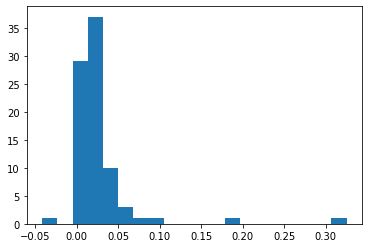

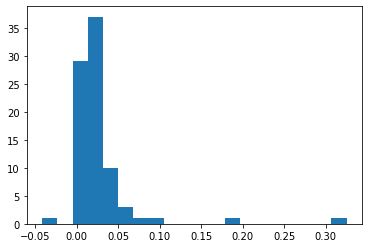

In [19]:
import matplotlib.pyplot as plt
plt.hist(Var1_np, bins=20)
plt.show()

plt.hist(Var1_np, bins=20)
plt.show()

In [ ]:
best_VaR_1 = min(Var1_np)
pd.set_option("display.max_columns", None)
best_VaR_1_idx = Var1_np.index(best_VaR_1)
print(companies_list.loc[[65]]) 

      Ticker                    Company      Sector           Subsector  \
index                                                                     
65       VBK  VERBIO VER.BIOENERGIE  ON  Industrial  Renewable Energies   

       Annual LogReturn       E      Risk  
index                                      
65             0.301294  0.0012  0.009964  


<Figure size 720x720 with 0 Axes>

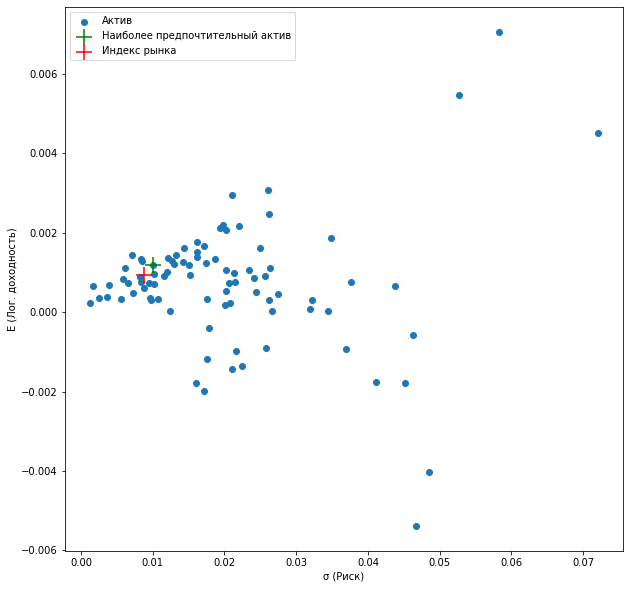

In [ ]:
plt.figure(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(companies_list['Risk'], companies_list['E'], label='Актив')
ax.scatter([0.009964], [0.0012], marker='+', color='green', s=[250], label='Наиболее предпочтительный актив') 
ax.scatter([dax_Risk], [dax_E], marker='+', color='red', s=[250], label='Индекс рынка')
ax.legend()
plt.xlabel('σ (Риск)')
plt.ylabel('E (Лог. доходность)')
plt.show()

Для гамма = 0.95

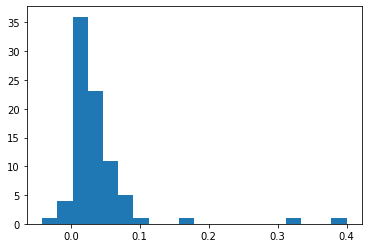

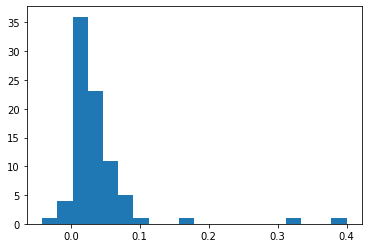

In [ ]:
import matplotlib.pyplot as plt
plt.hist(Var2_np, bins=20)
plt.show()

plt.hist(Var2_np, bins=20)
plt.show()

In [ ]:
best_VaR_2 = min(Var2_np)
pd.set_option("display.max_columns", None)
best_VaR_2_idx = Var2_np.index(best_VaR_2)
print(companies_list.loc[[61]]) 

      Ticker            Company              Sector    Subsector  \
index                                                              
61       TEG  TAG IMMOBILIEN AG  Financial Services  Real Estate   

       Annual LogReturn         E      Risk  
index                                        
61            -0.198762 -0.000903  0.025726  


<Figure size 720x720 with 0 Axes>

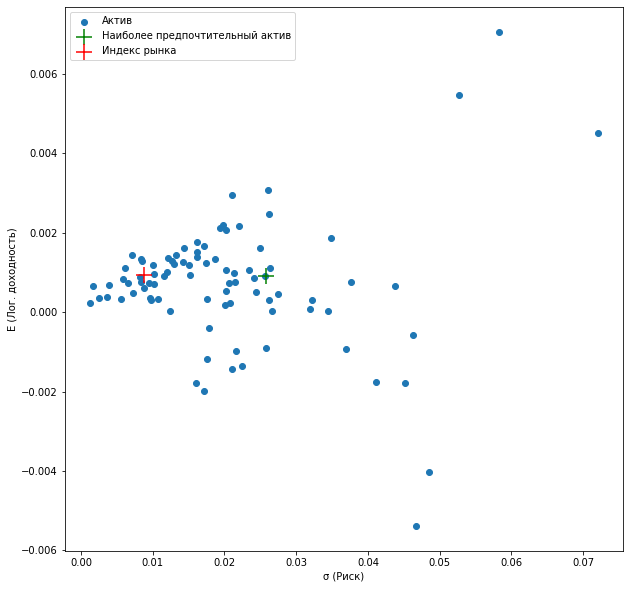

In [ ]:
plt.figure(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(companies_list['Risk'], companies_list['E'], label='Актив')
ax.scatter([0.025726  ], [0.000903], marker='+', color='green', s=[250], label='Наиболее предпочтительный актив') 
ax.scatter([dax_Risk], [dax_E], marker='+', color='red', s=[250], label='Индекс рынка')
ax.legend()
plt.xlabel('σ (Риск)')
plt.ylabel('E (Лог. доходность)')
plt.show()

VAR сбалансированного

In [ ]:
print(" Потери не превысят ",-np.quantile(companies_list['Annual LogReturn'], 1-0.9),  "с 90% уверенностью")
print(" Потери не превысят ",-np.quantile(companies_list['Annual LogReturn'], 1-0.95),  "с 95% уверенностью")

 Потери не превысят  0.2384776320969863 с 90% уверенностью
 Потери не превысят  0.3701266237375278 с 95% уверенностью


VAR индекса рынка

In [ ]:
log_returns = []
close_price = DAX_index['Adj Close']
log_returns.append(None)
for i in range(1, len(close_price)):
    log_return = (close_price[i] - close_price[i - 1]) / close_price[i - 1]
    log_returns.append(log_return)
print(" Потери не превысят ",-np.quantile(list(filter(None, log_returns)), 1-0.9),  "с 90% уверенностью")
print(" Потери не превысят ",-np.quantile(list(filter(None, log_returns)), 1-0.95),  "с 95% уверенностью")

 Потери не превысят  0.009496161660172338 с 90% уверенностью
 Потери не превысят  0.01569772061371343 с 95% уверенностью


По характеристике VaR индекс рынка является приоритетнее сбалансированного портфеля

# 6. Выберите несколько интересных (значимых) активов рынка. Можно ли считать наблюдаемые доходности (объемы продаж) конкретного актива повторной выборкой из некоторого распределения (белый шум)?

In [21]:
dax_companies = [5, 7, 34, 41, 44, 51]
for c in dax_companies:
    print(companies_list.loc[c]['Company'])

ADIDAS AG NA O.N.
ALLIANZ SE NA O.N.
HEIDELBERGCEMENT AG O.N.
LINDE PLC        EO 0,001
MERCK KGAA O.N.
SAP SE O.N.


Указанные выше компании были сочтены интересными, так как они входят в список 30 компаний, по которым рассчитывается индекс Франкфуртского фондового рынка **DAX**.

In [22]:
for i in dax_companies:
    print(len(tickers[i]))

252
252
252
252
252
252


По всем шести компаниям есть достаточное число наблюдений для проверки гипотезы.

### Гипотеза о случайности
$X = (X_1, X_2 ... X_n)$ - выборка.\
$H_0$ - гипотеза случайности. Если она верна, то случайные величины в выборке независимы и не являются повторной выборкой из распределения.\
$H_1$ - гипотеза случайности отвергается, данные являются повторной выборкой

#### Критерий инверсий
Говорят, что компоненты $X_i, X_j$ образуют инверсию, если $i<j$ и $X_i > X_j$
Общее число инверсий можно назвать рассматривать как статистику $T_n$ для выборки.\
Интервал значений статистики: $0 <= T_n <= \frac{n(n-1)}{2}$\
Чем ближе значение к границам интервала, тем больше **упорядоченность** данных. Гипотеза случайности отклоняется если данные упорядоченны, не хаотичны.

Матожидание и дисперсия статистики $T_n$ По Ивченко и Медведеву:\
$E(T_n)=\frac{n(n-1)}{4}$\
$D(T_n)=\frac{n(n-1)(2n+5)}{72}$

Гипотеза не будет отвергнута, если нормализованная статистика $T_n$ не будет превышать процентную точку для заданного уровня доверия $\alpha$.
Нормализованная статистика $T_n$ вычисляется по формуле: $\frac{T_n - E(T_n)}{\sqrt{D(T_n)}}$ \
Чаще всего уровень доверия $\alpha$ берется как 0.05

In [23]:
def count_inversions(arr):
    inv_count = 0
    for i in range(len(arr)-1):
        #print(i, end=', ')
        for j in arr[i+1:]:
            #print(j, end=' ')
            if arr[i] > j:
                inv_count += 1
        #print()
    return inv_count

In [24]:
import scipy.stats as stats

**Проверяем на случайность доходности**

In [25]:
for i in dax_companies:
    alpha = 0.05
    returns = tickers[i]['LogReturn']
    Tn = count_inversions(returns)
    n = len(returns)
    E_Tn = (n*(n-1))/4
    D_Tn = (n*(n-1)*(2*n+5))/72
    normalized_Tn = (Tn - E_Tn)/(D_Tn**(1/2))
    if abs(normalized_Tn) >= stats.norm.ppf(1 - alpha/2):
        print('Гипотеза для компании', companies_list.loc[i]['Company'], 'отвергается')
    else:
        print('Гипотеза для компании', companies_list.loc[i]['Company'], 'принимается')

Гипотеза для компании ADIDAS AG NA O.N. принимается
Гипотеза для компании ALLIANZ SE NA O.N. принимается
Гипотеза для компании HEIDELBERGCEMENT AG O.N. принимается
Гипотеза для компании LINDE PLC        EO 0,001 отвергается
Гипотеза для компании MERCK KGAA O.N. принимается
Гипотеза для компании SAP SE O.N. принимается


Делаем вывод, что данные по доходностям по всем компаниям, кроме "Linde", являются случайными.

**Проверяем на случайность объемы продаж**

In [26]:
for i in dax_companies:
    alpha = 0.05
    returns = tickers[i]['Volume']
    Tn = count_inversions(returns)
    n = len(returns)
    E_Tn = (n*(n-1))/4
    D_Tn = (n*(n-1)*(2*n+5))/72
    normalized_Tn = (Tn - E_Tn)/(D_Tn**(1/2))
    if abs(normalized_Tn) >= stats.norm.ppf(1 - alpha/2):
        print('Гипотеза для компании', companies_list.loc[i]['Company'], 'отвергается')
    else:
        print('Гипотеза для компании', companies_list.loc[i]['Company'], 'принимается')

Гипотеза для компании ADIDAS AG NA O.N. отвергается
Гипотеза для компании ALLIANZ SE NA O.N. отвергается
Гипотеза для компании HEIDELBERGCEMENT AG O.N. принимается
Гипотеза для компании LINDE PLC        EO 0,001 отвергается
Гипотеза для компании MERCK KGAA O.N. принимается
Гипотеза для компании SAP SE O.N. отвергается


Делаем вывод, что данные по объемам продаж являются случайными только для компаний "HEIDELBERGCEMENT" и "MERCK".

# 7. Выберите несколько интересных (значимых) активов рынка из разных производственных секторов. В предположении, что наблюдаемые доходности (объемы продаж) являются повторной выборкой из некоторого распределения исследовать (выборочно) распределения доходностей и объемов продаж выбранных активов.

Для отбора значимых активов используется кэффициент sharp-ratio.

In [ ]:
companies_list['SR'] = (companies_list['E'] - companies_list['E'][40])/ companies_list['Risk']

In [ ]:
companies_list.sort_values(by='SR')[-20:]

,Ticker,Company,Sector,Subsector,Annual LogReturn,E,Risk,SR
index,,,,,,,,
58,SNG,SINGULUS TECHNOL. EO 1,Industrial,Advanced Industrial Equipment,0.161064,0.001505,0.016149,0.041662
41,LIN,"LINDE PLC EO 0,001",Chemicals,Industrial Gases,0.340924,0.001358,0.012182,0.043159
76,NWX,NORDWEST HANDEL AG,Industrial,Industrial Products & Services,0.151251,0.001440,0.013307,0.045689
15,DEX,DELTICOM AG NA O.N.,Retail,"Retail, Internet",0.282209,0.001124,0.006126,0.047644
39,LEG,LEG IMMOBILIEN SE,Financial Services,Real Estate,0.417736,0.001664,0.017138,0.048536
26,FTK,FLATEXDEGIRO AG NA O.N.,Financial Services,Securities Brokers,1.131527,0.004508,0.072034,0.051026
73,GIB,GSW IMMOBILIEN AG,Financial Services,Real Estate,0.322667,0.001286,0.008524,0.053148
84,DAR,DATRON AG INH.O.N.,Industrial,Industrial Machinery,0.405402,0.001615,0.014372,0.054458
34,HEI,HEIDELBERGCEMENT AG O.N.,Construction,Building Materials,0.440789,0.001756,0.016160,0.057157


Получаем список активов, наиболее интересных к рассмотрению

In [ ]:
print(companies_list.loc[[58, 41, 15, 39, 34]])

      Ticker                    Company              Sector  \
index                                                         
58       SNG     SINGULUS TECHNOL. EO 1          Industrial   
41       LIN  LINDE PLC        EO 0,001           Chemicals   
15       DEX       DELTICOM AG  NA O.N.              Retail   
39       LEG          LEG IMMOBILIEN SE  Financial Services   
34       HEI   HEIDELBERGCEMENT AG O.N.        Construction   

                           Subsector  Annual LogReturn         E      Risk  \
index                                                                        
58     Advanced Industrial Equipment          0.161064  0.001505  0.016149   
41                  Industrial Gases          0.340924  0.001358  0.012182   
15                  Retail, Internet          0.282209  0.001124  0.006126   
39                       Real Estate          0.417736  0.001664  0.017138   
34                Building Materials          0.440789  0.001756  0.016160   

           

Предположим, что доходности выбранных активов имеют нормальное распределение, строим гистограммы доходностей

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


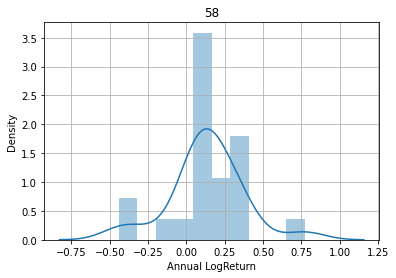

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


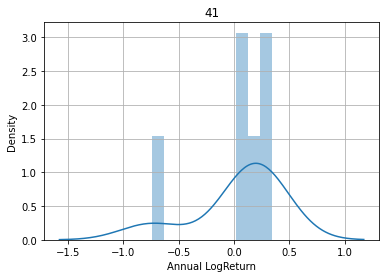

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


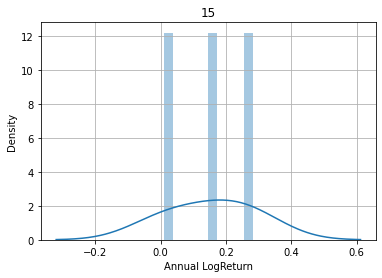

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


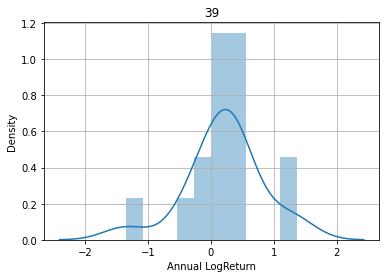

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


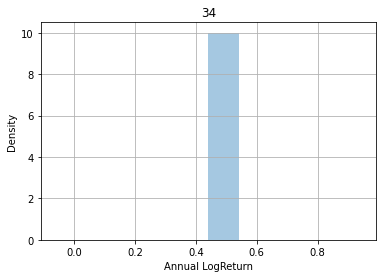

In [ ]:
import seaborn as sns
stocks_inds = [58, 41, 15, 39, 34]
for ind in stocks_inds:
  plt.grid()
  sns.distplot(companies_list[companies_list['Sector'] == companies_list.loc[ind][2]]['Annual LogReturn'], bins=10)
  plt.title("{}".format(ind))
  plt.show()

Построим тесты для проверки гипотезы о нормальности распределения доходности с уровнем значимости α = 0.05, для проверки полученных диаграмм. Используем тесты Шапиро, ДАгостино, Андерсона


In [ ]:
from scipy.stats import shapiro, normaltest, anderson
tests = {"Shapiro" : shapiro,
 "DAgostino" : normaltest,
 "Anderson" : anderson, }
def test_gipothesys(label, alfa=0.05):
  for test_name, test_f in tests.items():
    result = test_f(label)
    if test_name == 'Anderson':
      statistic = result[0]
      answer = 'отклоняется' if statistic > result[1][2] else 'не отклоняется'
      print("\t Гипотеза {} {}, статистика={:3f}".format(answer, test_name, statistic))
    else:
      p_value = result[1]
      answer = 'не отклоняется' if p_value > alfa else 'отклоняется'
      print("\t Гипотеза {} {}, p-value={:3f}".format(answer, test_name, p_value))


In [ ]:
stocks_names = [58, 41, 15, 39, 34]
stocks = ['SINGULUS TECHNOL. EO 1,Industrial', 'LINDE PLC EO 0,001,Chemicals', 'DELTICOM AG  NA O.N.,Retail', 'LEG IMMOBILIEN SE,Financial Services', 'HEIDELBERGCEMENT AG O.N.,Construction']
print('Доходности:\n\n')
k = 0
for label in stocks_names:
 print('\n', stocks[k], ':\n')
 k += 1
 test_gipothesys(tickers[label]['LogReturn'].dropna())

Доходности:



 SINGULUS TECHNOL. EO 1,Industrial :

	 Гипотеза отклоняется Shapiro, p-value=0.000000
	 Гипотеза отклоняется DAgostino, p-value=0.000000
	 Гипотеза отклоняется Anderson, статистика=1.350660

 LINDE PLC EO 0,001,Chemicals :

	 Гипотеза отклоняется Shapiro, p-value=0.000000
	 Гипотеза отклоняется DAgostino, p-value=0.000000
	 Гипотеза отклоняется Anderson, статистика=5.350278

 DELTICOM AG  NA O.N.,Retail :

	 Гипотеза не отклоняется Shapiro, p-value=0.093556
	 Гипотеза не отклоняется DAgostino, p-value=0.080521
	 Гипотеза не отклоняется Anderson, статистика=0.647088

 LEG IMMOBILIEN SE,Financial Services :

	 Гипотеза отклоняется Shapiro, p-value=0.000049
	 Гипотеза отклоняется DAgostino, p-value=0.000007
	 Гипотеза отклоняется Anderson, статистика=1.482762

 HEIDELBERGCEMENT AG O.N.,Construction :

	 Гипотеза не отклоняется Shapiro, p-value=0.343411
	 Гипотеза не отклоняется DAgostino, p-value=0.278105
	 Гипотеза не отклоняется Anderson, статистика=0.562861


Для двух активов: DELTICOM AG  NA O.N.,Retail и HEIDELBERGCEMENT AG O.N.,Construction гипотеза о нормальности не отвергается.
Рассмотрим эти два актива

No handles with labels found to put in legend.


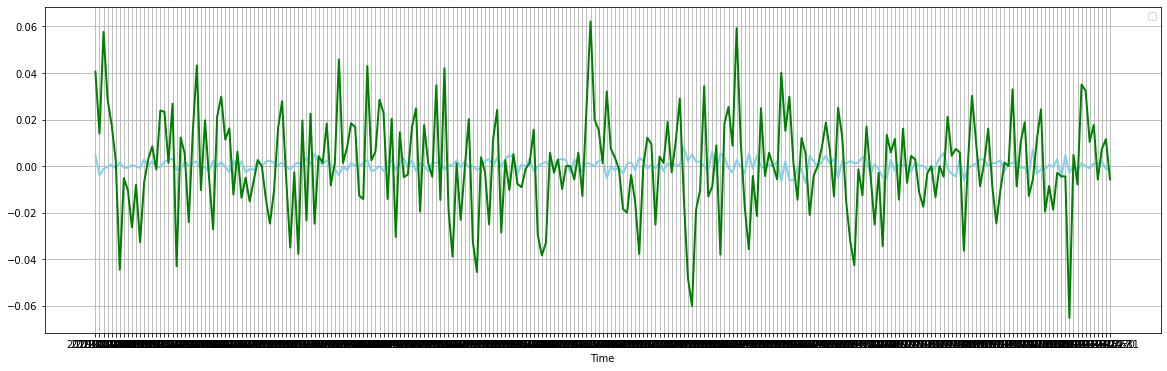

In [ ]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

def plot_stock(y):
 y1 = tickers[15]['LogReturn'].dropna()
 y2 = tickers[34]['LogReturn'].dropna()
 x1 = tickers[15]['LogReturn'].dropna().keys()

 figure(figsize=(20, 6))
 plt.grid()
 plt.plot(x1, y1, marker='', color='skyblue', linewidth=2)
 plt.plot(x1, y2, marker='', color='green', linewidth=2)
 plt.xlabel('Time')
 plt.legend()


plot_stock('LogReturn')

No handles with labels found to put in legend.


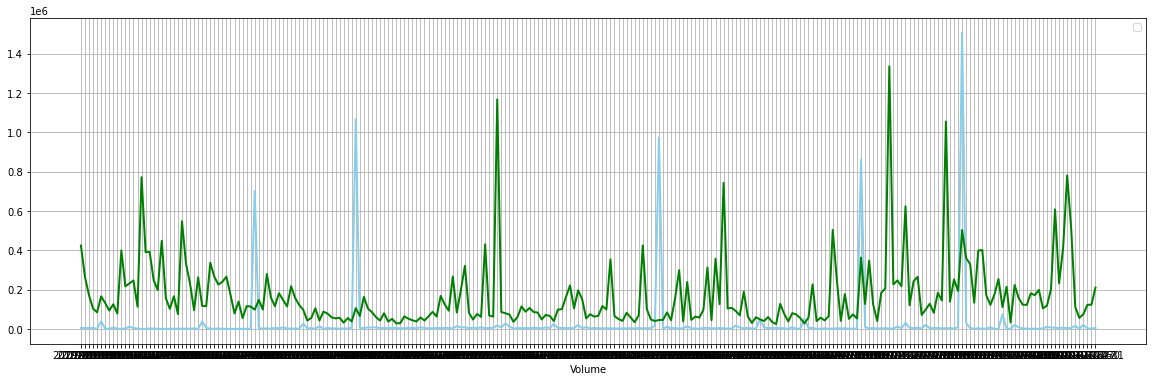

In [ ]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

def plot_stock(y):
 y1 = tickers[15]['Volume'].dropna()
 y2 = tickers[34]['Volume'].dropna()
 x1 = tickers[15]['Volume'].dropna().keys()
 x1 = tickers[15]['Volume'].dropna().keys()

 figure(figsize=(20, 6))
 plt.grid()
 plt.plot(x1, y1, marker='', color='skyblue', linewidth=2)
 plt.plot(x1, y2, marker='', color='green', linewidth=2)
 plt.xlabel('Volume')
 plt.legend()


plot_stock('Volume')

По графику можно заметить, что тренды доходностей и объёмов продаж у обеих компаний не совпадают, не смотря одинаковое распределение. Такие результаты мы можем наблюдать по причине того, что активы взяты из разных секторов. Такие активы могут не иметь общих внешних факторов.

# 8. Исследовать зависимости (выборочно) между доходностями различных активов с помощью техники анализа зависимостей.


In [ ]:
!pip install prettytable
from prettytable import PrettyTable
def some_print(df):
 x = PrettyTable()
 x.field_names = df.columns.tolist()
 for row in df.values:
  x.add_row(row)
 print(x)
 return x


Найдём корреляцию между случайными величинами для того, чтобы определить есть ли между ними зависмость

Анализ зависимости доходностей у активов из одного производственного сектора:

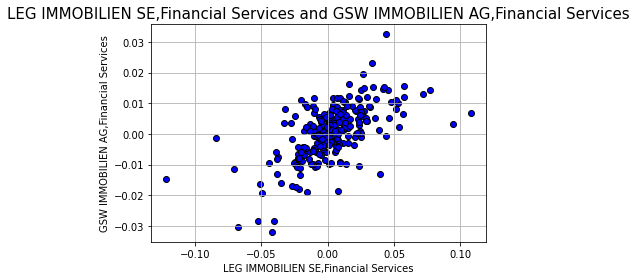

+--------------------------------------+--------------------------------------+
| LEG IMMOBILIEN SE,Financial Services | GSW IMMOBILIEN AG,Financial Services |
+--------------------------------------+--------------------------------------+
|                 1.0                  |          0.6128027313132239          |
|          0.6128027313132239          |                 1.0                  |
+--------------------------------------+--------------------------------------+
Коэффициент корреляции между LEG IMMOBILIEN SE,Financial Services  и GSW IMMOBILIEN AG,Financial Services  равен 0.613


In [ ]:
import numpy as np

stock2 = tickers[39]['LogReturn'].dropna()
stock1 = tickers[73]['LogReturn'].dropna()
if (len(stock1) > len(stock2)):
  stock1 = stock1[:len(stock2)]
if (len(stock2) > len(stock1)):
  stock2 = stock2[:len(stock1)]

keys = ['LEG IMMOBILIEN SE,Financial Services', 'GSW IMMOBILIEN AG,Financial Services']
if stock1.shape != stock2.shape:
  new_size = stock1.shape[0]
  stock1 = stock1[:new_size]
  stock2 = stock2[:new_size]
concat_pd = pd.concat([stock1, stock2], axis=1, sort=False, keys=keys)
corr = concat_pd.corr()
corr_value = np.corrcoef(stock1,stock2)[0][1]

plt.grid()
plt.scatter(stock1, stock2,c = 'blue', edgecolors='black')
plt.xlabel(keys[0])
plt.ylabel(keys[1])
plt.title('LEG IMMOBILIEN SE,Financial Services'+' and '+'GSW IMMOBILIEN AG,Financial Services', size=15)
plt.show()
some_print(corr)
print(f'Коэффициент корреляции между LEG IMMOBILIEN SE,Financial Services  и GSW IMMOBILIEN AG,Financial Services  равен {round(corr_value, 3)}')

Коэфициент корреляции 0.613 свидетельствует о линейной зависимости. что подтверждается графиком.
Активы LEG IMMOBILIEN SE,Financial Services и GSW IMMOBILIEN AG,Financial Services из финансового производственного сектора зависимы между собой.

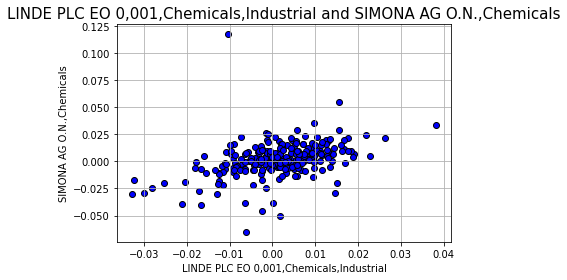

+-----------------------------------------+--------------------------+
| LINDE PLC EO 0,001,Chemicals,Industrial | SIMONA AG O.N.,Chemicals |
+-----------------------------------------+--------------------------+
|                   1.0                   |    0.4138570341686347    |
|            0.4138570341686347           |           1.0            |
+-----------------------------------------+--------------------------+
Коэффициент корреляции между 4LINDE PLC EO 0,001,Chemicals,Industrial  и SIMONA AG O.N.,Chemicals  равен 0.414


In [ ]:
import numpy as np

stock2 = tickers[41]['LogReturn'].dropna()
stock1 = tickers[79]['LogReturn'].dropna()
if (len(stock1) > len(stock2)):
  stock1 = stock1[:len(stock2)]
if (len(stock2) > len(stock1)):
  stock2 = stock2[:len(stock1)]

keys = ['LINDE PLC EO 0,001,Chemicals,Industrial', 'SIMONA AG O.N.,Chemicals']
if stock1.shape != stock2.shape:
  new_size = stock1.shape[0]
  stock1 = stock1[:new_size]
  stock2 = stock2[:new_size]
concat_pd = pd.concat([stock1, stock2], axis=1, sort=False, keys=keys)
corr = concat_pd.corr()
corr_value = np.corrcoef(stock1,stock2)[0][1]

plt.grid()
plt.scatter(stock1, stock2,c = 'blue', edgecolors='black')
plt.xlabel(keys[0])
plt.ylabel(keys[1])
plt.title('LINDE PLC EO 0,001,Chemicals,Industrial'+' and '+'SIMONA AG O.N.,Chemicals', size=15)
plt.show()
some_print(corr)
print(f'Коэффициент корреляции между 4LINDE PLC EO 0,001,Chemicals,Industrial  и SIMONA AG O.N.,Chemicals  равен {round(corr_value, 3)}')

Коэфициент корреляции 0.414 > 0, что говорит о прямой линейной зависимости. что подтверждается графиком.
Активы LINDE PLC EO 0,001,Chemicals,Industrial и SIMONA AG O.N.,Chemicals из сектора производства химикатов зависимы между собой.

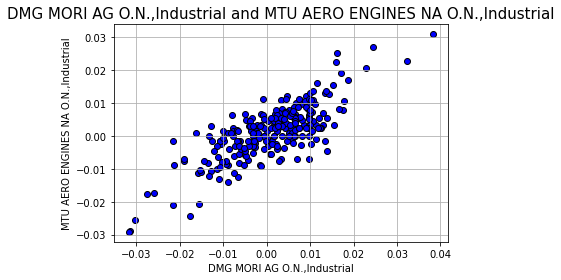

+-----------------------------+-------------------------------------+
| DMG MORI AG O.N.,Industrial | MTU AERO ENGINES NA O.N.,Industrial |
+-----------------------------+-------------------------------------+
|             1.0             |          0.7927018914146947         |
|      0.7927018914146947     |                 1.0                 |
+-----------------------------+-------------------------------------+
Коэффициент корреляции между DMG MORI AG O.N.,Industrial  и MTU AERO ENGINES NA O.N.,Industrial  равен 0.793


In [ ]:
import numpy as np

stock2 = tickers[20]['LogReturn'].dropna()
stock1 = tickers[46]['LogReturn'].dropna()
if (len(stock1) > len(stock2)):
  stock1 = stock1[:len(stock2)]
if (len(stock2) > len(stock1)):
  stock2 = stock2[:len(stock1)]

keys = ['DMG MORI AG O.N.,Industrial', 'MTU AERO ENGINES NA O.N.,Industrial']
if stock1.shape != stock2.shape:
  new_size = stock1.shape[0]
  stock1 = stock1[:new_size]
  stock2 = stock2[:new_size]
concat_pd = pd.concat([stock1, stock2], axis=1, sort=False, keys=keys)
corr = concat_pd.corr()
corr_value = np.corrcoef(stock1,stock2)[0][1]

plt.grid()
plt.scatter(stock1, stock2,c = 'blue', edgecolors='black')
plt.xlabel(keys[0])
plt.ylabel(keys[1])
plt.title('DMG MORI AG O.N.,Industrial'+' and '+'MTU AERO ENGINES NA O.N.,Industrial', size=15)
plt.show()
some_print(corr)
print(f'Коэффициент корреляции между DMG MORI AG O.N.,Industrial  и MTU AERO ENGINES NA O.N.,Industrial  равен {round(corr_value, 3)}')

Коэфициент корреляции 0.793 свидетельствует о сильной линейной зависимости. что подтверждается графиком.
Активы DMG MORI AG O.N.,Industrial и MTU AERO ENGINES NA O.N.,Industrial из промышленного производственного сектора зависимы между собой.


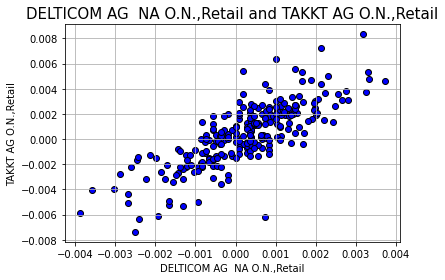

+-----------------------------+----------------------+
| DELTICOM AG  NA O.N.,Retail | TAKKT AG O.N.,Retail |
+-----------------------------+----------------------+
|             1.0             |  0.7920305428228769  |
|      0.7920305428228769     |         1.0          |
+-----------------------------+----------------------+
Коэффициент корреляции между DELTICOM AG  NA O.N.,Retail  и TAKKT AG O.N.,Retail  равен 0.792


In [ ]:
import numpy as np

stock2 = tickers[15]['LogReturn'].dropna()
stock1 = tickers[52]['LogReturn'].dropna()
if (len(stock1) > len(stock2)):
  stock1 = stock1[:len(stock2)]
if (len(stock2) > len(stock1)):
  stock2 = stock2[:len(stock1)]

keys = ['DELTICOM AG  NA O.N.,Retail', 'TAKKT AG O.N.,Retail']
if stock1.shape != stock2.shape:
  new_size = stock1.shape[0]
  stock1 = stock1[:new_size]
  stock2 = stock2[:new_size]
concat_pd = pd.concat([stock1, stock2], axis=1, sort=False, keys=keys)
corr = concat_pd.corr()
corr_value = np.corrcoef(stock1,stock2)[0][1]

plt.grid()
plt.scatter(stock1, stock2,c = 'blue', edgecolors='black')
plt.xlabel(keys[0])
plt.ylabel(keys[1])
plt.title('DELTICOM AG  NA O.N.,Retail'+' and '+'TAKKT AG O.N.,Retail', size=15)
plt.show()
some_print(corr)
print(f'Коэффициент корреляции между DELTICOM AG  NA O.N.,Retail  и TAKKT AG O.N.,Retail  равен {round(corr_value, 3)}')

Коэфициент корреляции 0.792 свидетельствует о сильной линейной зависимости. что подтверждается графиком.
Активы DELTICOM AG  NA O.N.,Retail и TAKKT AG O.N.,Retail из сектора розничной торговли зависимы между собой.

Анализ зависимости доходностей у активов из разных производственных секторов:

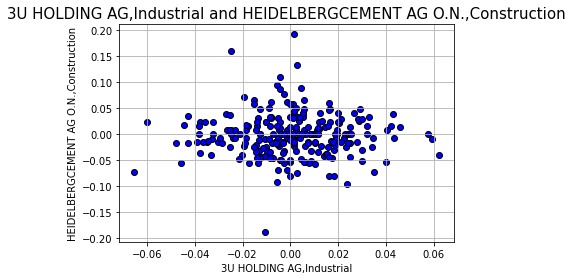

+--------------------------+---------------------------------------+
| 3U HOLDING AG,Industrial | HEIDELBERGCEMENT AG O.N.,Construction |
+--------------------------+---------------------------------------+
|           1.0            |         -0.009228754923385605         |
|  -0.009228754923385605   |                  1.0                  |
+--------------------------+---------------------------------------+
Коэффициент корреляции между 3U HOLDING AG,Industrial  и HEIDELBERGCEMENT AG O.N.,Construction  равен -0.009


In [ ]:
import numpy as np

stock2 = tickers[1]['LogReturn'].dropna()
stock1 = tickers[34]['LogReturn'].dropna()
if (len(stock1) > len(stock2)):
  stock1 = stock1[:len(stock2)]
if (len(stock2) > len(stock1)):
  stock2 = stock2[:len(stock1)]

keys = ['3U HOLDING AG,Industrial', 'HEIDELBERGCEMENT AG O.N.,Construction']
if stock1.shape != stock2.shape:
  new_size = stock1.shape[0]
  stock1 = stock1[:new_size]
  stock2 = stock2[:new_size]
concat_pd = pd.concat([stock1, stock2], axis=1, sort=False, keys=keys)
corr = concat_pd.corr()
corr_value = np.corrcoef(stock1,stock2)[0][1]

plt.grid()
plt.scatter(stock1, stock2,c = 'blue', edgecolors='black')
plt.xlabel(keys[0])
plt.ylabel(keys[1])
plt.title('3U HOLDING AG,Industrial'+' and '+'HEIDELBERGCEMENT AG O.N.,Construction', size=15)
plt.show()
some_print(corr)
print(f'Коэффициент корреляции между 3U HOLDING AG,Industrial  и HEIDELBERGCEMENT AG O.N.,Construction  равен {round(corr_value, 3)}')

Коэффициент корреляции близок к нулю. Это говорить об отсутствии зависимость между активами 3U HOLDING AG,Industrial промышленного производства и HEIDELBERGCEMENT AG O.N.,Construction из строительного сектора. Возможно отсутствуют факторы одновременно влияющие на два этих сектора.

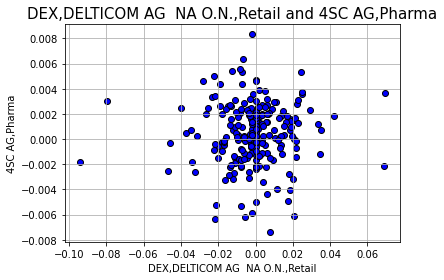

+---------------------------------+----------------------+
| DEX,DELTICOM AG  NA O.N.,Retail |    4SC AG,Pharma     |
+---------------------------------+----------------------+
|               1.0               | 0.013934416215571125 |
|       0.013934416215571125      |         1.0          |
+---------------------------------+----------------------+
Коэффициент корреляции между DEX,DELTICOM AG  NA O.N.,Retail  и 4SC AG,Pharma  равен 0.033


In [ ]:
import numpy as np

stock2 = tickers[15]['LogReturn'].dropna()
stock1 = tickers[2]['LogReturn'].dropna()
if (len(stock1) > len(stock2)):
  stock1 = stock1[:len(stock2)]
if (len(stock2) > len(stock1)):
  stock2 = stock2[:len(stock1)]

keys = ['DEX,DELTICOM AG  NA O.N.,Retail', '4SC AG,Pharma']
if stock1.shape != stock2.shape:
  new_size = stock1.shape[0]
  stock1 = stock1[:new_size]
  stock2 = stock2[:new_size]
concat_pd = pd.concat([stock1, stock2], axis=1, sort=False, keys=keys)
corr = concat_pd.corr()
corr_value = np.corrcoef(stock1,stock2)[0][1]

plt.grid()
plt.scatter(stock1, stock2,c = 'blue', edgecolors='black')
plt.xlabel(keys[0])
plt.ylabel(keys[1])
plt.title('DEX,DELTICOM AG  NA O.N.,Retail'+' and '+'4SC AG,Pharma', size=15)
plt.show()
some_print(corr)
print(f'Коэффициент корреляции между DEX,DELTICOM AG  NA O.N.,Retail  и 4SC AG,Pharma  равен {round(corr_value, 3)}')

Коэффициент корреляции близок к нулю, активы DEX,DELTICOM AG  NA O.N.,Retail и 4SC AG,Pharma независимы друг от друга.

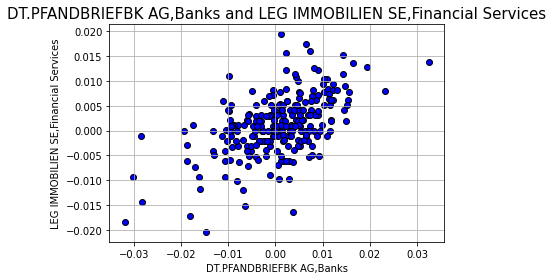

+--------------------------+--------------------------------------+
| DT.PFANDBRIEFBK AG,Banks | LEG IMMOBILIEN SE,Financial Services |
+--------------------------+--------------------------------------+
|           1.0            |          0.5550773385589292          |
|    0.5550773385589292    |                 1.0                  |
+--------------------------+--------------------------------------+
Коэффициент корреляции между DT.PFANDBRIEFBK AG,Banks  и LEG IMMOBILIEN SE,Financial Services  равен 0.555


In [ ]:
import numpy as np

stock2 = tickers[21]['LogReturn'].dropna()
stock1 = tickers[39]['LogReturn'].dropna()
if (len(stock1) > len(stock2)):
  stock1 = stock1[:len(stock2)]
if (len(stock2) > len(stock1)):
  stock2 = stock2[:len(stock1)]

keys = ['DT.PFANDBRIEFBK AG,Banks', 'LEG IMMOBILIEN SE,Financial Services']
if stock1.shape != stock2.shape:
  new_size = stock1.shape[0]
  stock1 = stock1[:new_size]
  stock2 = stock2[:new_size]
concat_pd = pd.concat([stock1, stock2], axis=1, sort=False, keys=keys)
corr = concat_pd.corr()
corr_value = np.corrcoef(stock1,stock2)[0][1]

plt.grid()
plt.scatter(stock1, stock2,c = 'blue', edgecolors='black')
plt.xlabel(keys[0])
plt.ylabel(keys[1])
plt.title('DT.PFANDBRIEFBK AG,Banks'+' and '+'LEG IMMOBILIEN SE,Financial Services', size=15)
plt.show()
some_print(corr)
print(f'Коэффициент корреляции между DT.PFANDBRIEFBK AG,Banks  и LEG IMMOBILIEN SE,Financial Services  равен {round(corr_value, 3)}')

Коэфициент корреляции 0.555 свидетельствует о наличие линейной зависимости, показанной на графике.
Активы DT.PFANDBRIEFBK AG,Banks и LEG IMMOBILIEN SE,Financial Services из из разных производственных секторов зависимы между собой. Этот факт можно объяснить наличием влияния сфер
друг на друга, общих факторов из вне, так как финансовая сфера и банки тесно связаны друг с другом


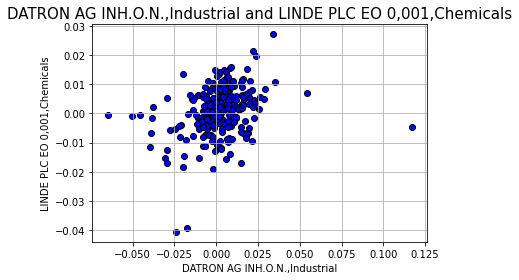

+-------------------------------+------------------------------+
| DATRON AG INH.O.N.,Industrial | LINDE PLC EO 0,001,Chemicals |
+-------------------------------+------------------------------+
|              1.0              |      0.3095313327304225      |
|       0.3095313327304225      |             1.0              |
+-------------------------------+------------------------------+
Коэффициент корреляции между DATRON AG INH.O.N.,Industrial  и LINDE PLC EO 0,001,Chemicals  равен 0.31


In [ ]:
import numpy as np

stock2 = tickers[84]['LogReturn'].dropna()
stock1 = tickers[41]['LogReturn'].dropna()
if (len(stock1) > len(stock2)):
  stock1 = stock1[:len(stock2)]
if (len(stock2) > len(stock1)):
  stock2 = stock2[:len(stock1)]

keys = ['DATRON AG INH.O.N.,Industrial', 'LINDE PLC EO 0,001,Chemicals']
if stock1.shape != stock2.shape:
  new_size = stock1.shape[0]
  stock1 = stock1[:new_size]
  stock2 = stock2[:new_size]
concat_pd = pd.concat([stock1, stock2], axis=1, sort=False, keys=keys)
corr = concat_pd.corr()
corr_value = np.corrcoef(stock1,stock2)[0][1]

plt.grid()
plt.scatter(stock1, stock2,c = 'blue', edgecolors='black')
plt.xlabel(keys[0])
plt.ylabel(keys[1])
plt.title('DATRON AG INH.O.N.,Industrial'+' and '+'LINDE PLC EO 0,001,Chemicals', size=15)
plt.show()
some_print(corr)
print(f'Коэффициент корреляции между DATRON AG INH.O.N.,Industrial  и LINDE PLC EO 0,001,Chemicals  равен {round(corr_value, 3)}')

Активы DATRON AG INH.O.N.,Industrial и LINDE PLC EO 0,001,Chemicals из разных производственных секторов зависимы между собой.

Анализ зависимости объема продаж с доходностями у одного актива

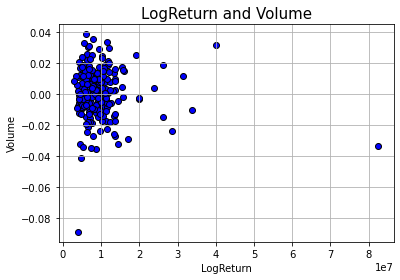

+----------------------+----------------------+
|      LogReturn       |        Volume        |
+----------------------+----------------------+
|         1.0          | -0.10339050237405353 |
| -0.10339050237405353 |         1.0          |
+----------------------+----------------------+
Коэффициент корреляции между доходностью и объёмом продаж актива SINGULUS TECHNOL. EO 1,Industrial равен -0.076


In [ ]:
import numpy as np

log = tickers[58]['LogReturn'].dropna()
volume = tickers[58]['Volume'].dropna()
if (len(log) > len(volume)):
  log = log[:len(volume)]
if (len(volume) > len(log)):
  volume = volume[:len(log)]
keys = ['LogReturn', 'Volume']
if volume.shape != log.shape:
  new_size = volume.shape[0]
  volume = volume[:new_size]
  log = log[:new_size]
concat_pd = pd.concat([volume, log], axis=1, sort=False, keys=keys)
corr = concat_pd.corr()
corr_value = np.corrcoef(volume,log)[0][1]

plt.grid()
plt.scatter(volume, log,c = 'blue', edgecolors='black')
plt.xlabel(keys[0])
plt.ylabel(keys[1])
plt.title('LogReturn and Volume', size=15)
plt.show()
some_print(corr)
print(f'Коэффициент корреляции между доходностью и объёмом продаж актива SINGULUS TECHNOL. EO 1,Industrial равен {round(corr_value, 3)}')

Коэффициент корреляции отрицательный и близок к нулю, что говорит об отсутствие зависимости между доходностями и объемом продаж у актива.


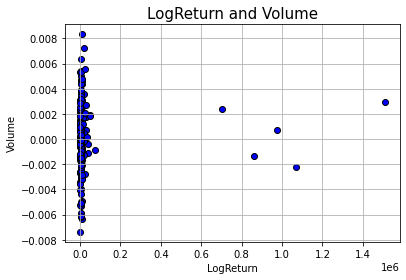

+---------------------+---------------------+
|      LogReturn      |        Volume       |
+---------------------+---------------------+
|         1.0         | 0.05908545511627738 |
| 0.05908545511627738 |         1.0         |
+---------------------+---------------------+
Коэффициент корреляции между доходностью и объёмом продаж актива DELTICOM AG  NA O.N.,Retail равен 0.021


In [ ]:
import numpy as np

log = tickers[15]['LogReturn'].dropna()
volume = tickers[15]['Volume'].dropna()
if (len(log) > len(volume)):
  log = log[:len(volume)]
if (len(volume) > len(log)):
  volume = volume[:len(log)]
keys = ['LogReturn', 'Volume']
if volume.shape != log.shape:
  new_size = volume.shape[0]
  volume = volume[:new_size]
  log = log[:new_size]
concat_pd = pd.concat([volume, log], axis=1, sort=False, keys=keys)
corr = concat_pd.corr()
corr_value = np.corrcoef(volume,log)[0][1]

plt.grid()
plt.scatter(volume, log,c = 'blue', edgecolors='black')
plt.xlabel(keys[0])
plt.ylabel(keys[1])
plt.title('LogReturn and Volume', size=15)
plt.show()
some_print(corr)
print(f'Коэффициент корреляции между доходностью и объёмом продаж актива DELTICOM AG  NA O.N.,Retail равен {round(corr_value, 3)}')

Коэффициент корреляции положительный и близок к нулю, что говорит об отсутствие зависимости между доходностями и объемом продаж у актива.


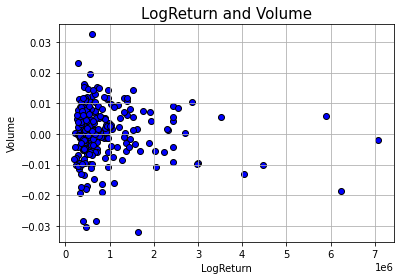

+---------------------+---------------------+
|      LogReturn      |        Volume       |
+---------------------+---------------------+
|         1.0         | 0.09216832332849426 |
| 0.09216832332849426 |         1.0         |
+---------------------+---------------------+
Коэффициент корреляции между доходностью и объёмом продаж актива LEG IMMOBILIEN SE,Financial Services равен -0.091


In [ ]:
import numpy as np

log = tickers[39]['LogReturn'].dropna()
volume = tickers[39]['Volume'].dropna()
if (len(log) > len(volume)):
  log = log[:len(volume)]
if (len(volume) > len(log)):
  volume = volume[:len(log)]
keys = ['LogReturn', 'Volume']
if volume.shape != log.shape:
  new_size = volume.shape[0]
  volume = volume[:new_size]
  log = log[:new_size]
concat_pd = pd.concat([volume, log], axis=1, sort=False, keys=keys)
corr = concat_pd.corr()
corr_value = np.corrcoef(volume,log)[0][1]

plt.grid()
plt.scatter(volume, log,c = 'blue', edgecolors='black')
plt.xlabel(keys[0])
plt.ylabel(keys[1])
plt.title('LogReturn and Volume', size=15)
plt.show()
some_print(corr)
print(f'Коэффициент корреляции между доходностью и объёмом продаж актива LEG IMMOBILIEN SE,Financial Services равен {round(corr_value, 3)}')

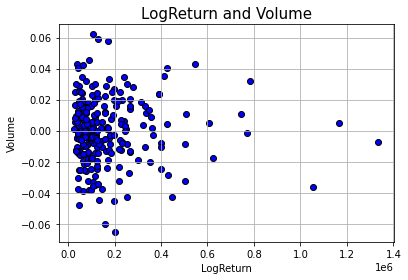

+----------------------+----------------------+
|      LogReturn       |        Volume        |
+----------------------+----------------------+
|         1.0          | 0.013185315062883339 |
| 0.013185315062883339 |         1.0          |
+----------------------+----------------------+
Коэффициент корреляции между доходностью и объёмом продаж актива HEIDELBERGCEMENT AG O.N.,Construction равен -0.017


In [ ]:
import numpy as np

log = tickers[34]['LogReturn'].dropna()
volume = tickers[34]['Volume'].dropna()
if (len(log) > len(volume)):
  log = log[:len(volume)]
if (len(volume) > len(log)):
  volume = volume[:len(log)]
keys = ['LogReturn', 'Volume']
if volume.shape != log.shape:
  new_size = volume.shape[0]
  volume = volume[:new_size]
  log = log[:new_size]
concat_pd = pd.concat([volume, log], axis=1, sort=False, keys=keys)
corr = concat_pd.corr()
corr_value = np.corrcoef(volume,log)[0][1]

plt.grid()
plt.scatter(volume, log,c = 'blue', edgecolors='black')
plt.xlabel(keys[0])
plt.ylabel(keys[1])
plt.title('LogReturn and Volume', size=15)
plt.show()
some_print(corr)
print(f'Коэффициент корреляции между доходностью и объёмом продаж актива HEIDELBERGCEMENT AG O.N.,Construction равен {round(corr_value, 3)}')

Коэффициенты корреляции отрицательные и близки к нулю, что говорит об отсутствие зависимости между доходностями и объемом продаж у активов.
